# 监督学习 Supervised Learning

引入科学计算和绘图相关包

In [1]:
import logging
from collections import namedtuple

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from IPython.display import HTML
from sklearn.linear_model import LinearRegression

# 引入绘图包
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
sns.set_style('whitegrid')
logging.basicConfig(level=logging.INFO)
%matplotlib inline

引入波士顿房价数据

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

我们仅使用RM（平均房间数）和Price（按1000美元计的房价中位数）两个指标。

绘制平均房间数和房价中位数的散点图

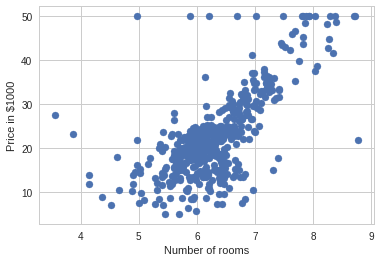

In [3]:
df = DataFrame(data=boston.data, columns=boston.feature_names)[["RM"]].join(DataFrame(data=boston.target, columns=["Price"]))
plt.scatter(df["RM"], df["Price"])
plt.xlabel("Number of rooms")
plt.ylabel("Price in $1000")

为了方便描述，我们这里引入一些符号。$x^{(i)}$ 用来表示输入变量，比如这里的平均房间数，它也被称为**特征features**。$y^{(i)}$ 用来表示输出变量，或我们希望预测的**目标target**变量。一对 $(x^{(i)}, y^{(i)})$ 称为一个**训练样本training example**，而我们将使用的 $m$ 个训练样本 $\{(x^{(i)}, y^{(i)});i=1,...,m\}$ 的集合称为**训练集training set**。注意这里的上标 $(i)$ 是对训练集的一个索引编号，不是幂运算。我们用 $\chi$ 表示输入空间，$\gamma$ 表示输出空间。在这个例子中 $\chi=\gamma=\mathbb{R}$

正式地定义监督学习：给定一个训练集，我们希望学习到一个函数 $h: \chi \rightarrow \gamma$，使得 $h(x)$ 可以很好地预测 $y$。由于历史原因，函数 $h$ 被称为**假设hypothesis**。

当我们希望预测的目标变量是连续型变量时，比如这里的房价，我们称这是一个**回归Regression**问题。当 $y$ 仅仅只取少数离散值时，我们称这是一个**分类Classification**问题。

# 线性回归 Linear Regression

包括以下内容：
    1. 最小二乘法 LMS algorithm
    2. 正规方程 The normal equations
    3. 概率诠释 Probabilistic interpretation
    4. 局部加权线性回归 Locally weighted linear regression

In [4]:
# 预览数据
print(df.head())

      RM  Price
0  6.575   24.0
1  6.421   21.6
2  7.185   34.7
3  6.998   33.4
4  7.147   36.2


对于这个数据集，$x$ 是一个$\mathbb{R}$上的一维向量。$x_1^i$是该区域的平均房间数。

要进行监督学习，我们需要首先决定如何来表示假设/函数 $h$。较为简单的情况下，我们选取 $x$ 的线性函数来预测 $y$ ：
$$ h_\theta(x) = \theta_0 + \theta_1x_1 $$
这里，$\theta_i$称为**参数parameters**（有时也称为**权重weights**），通过这组参数，我们将 $\chi$ 线性映射到 $\gamma$。在不引发误解的情况下，我们将 $h_\theta(x)$简写为 $h(x)$。习惯上，我们设 $x_0=1$ （称为**截距项intercept term**）,这样
$$ h(x) = \sum_{i=0}^n \theta_ix_i = \theta^Tx $$
对于右式，我们将 $\theta$ 和 $x$ 看做向量，$n$ 是特征数量（不包括 $x_0$ )

这样，给定训练集，我们需要挑选，或者说学习出参数 $\theta$ 的值。一个直观的方法是使 $h(x)$ 尽量接近 $y$，至少对于训练集来说，尽量地接近。为了更正式地定义“接近”，我们定义**成本函数cost function**：
$$ J(\theta) = \frac{1}{2}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)})^2$$

## 1. 最小二乘法 Linear Regression

我们希望挑选出使 $J(\theta)$ 最小化的值 $\theta$。一种搜索算法的思路是，我们随机猜测一个 $\theta$，然后按某种规则重复地改变 $\theta$ 使得 $J(\theta)$ 不断变小，直到 $\theta$ 收敛到某个值使得 $J(\theta)$ 取得最小值。

特别地，我们将考虑**梯度下降Gradient Descent**算法。如下图所示，$J(\theta)$ 是关于 $\theta_0$ 和 $\theta_1$ 的函数。首先我们随机选择一个 $ \theta = [-10, 17.5]$，想象在图形中下坡，我们需要选择一个下降最快的方向。不断地前进，直到来到某个**局域最小值local minima**。在我们的图中，只有一个**全局最小值global minima**（以红星标记）。但梯度下降的一个特性是，当存在局域最小值时，根据随机选择初始化 $\theta$ 的不同，我们可能会到达不同的局域最小值。局部最小值的问题，在今后的模型中会遇到。

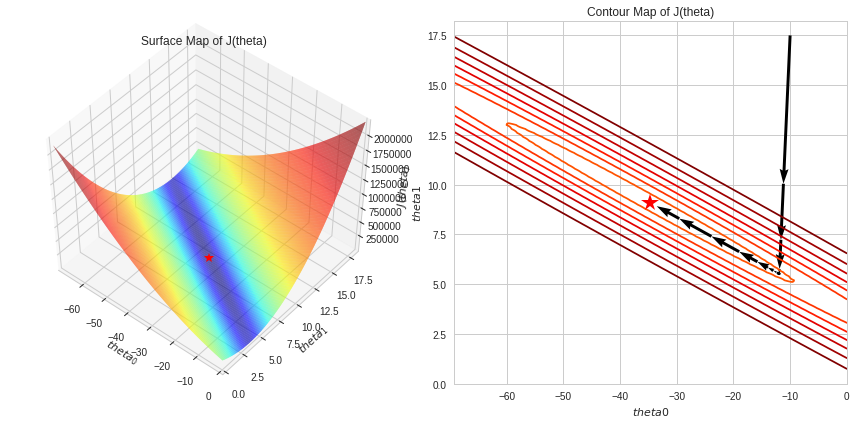

In [9]:
# 读取训练集和目标变量
X, y = df[["RM"]].values, df["Price"].values
m, n = X.shape
# 增加截距列
X_intercept = np.column_stack((np.ones((m, 1)), X))


@np.vectorize
def cost_function(*args):
    """成本函数"""
    theta = np.array(args)
    return 0.5 * ((X_intercept @ theta - y) ** 2).sum()


def gradient_descent_optimize(cost_func, init_theta=None):
    """使用梯度下降寻找最优的theta"""
    alpha = 0.00003

    def good_enough(old_cost, new_cost):
        return np.abs(new_cost - old_cost) / old_cost < 0.00000001

    def improve_theta(old_theta):
        return old_theta - alpha * ((X_intercept @ old_theta - y) @ X_intercept)

    if init_theta is None:
        init_theta = np.array([0, 0])
    path_ = [init_theta]
    o_theta, o_cost = init_theta, cost_function(*init_theta)
    while True:
        n_theta = improve_theta(o_theta)
        n_cost = cost_func(*n_theta)
        path_.append(n_theta)
        logging.debug((o_theta, n_theta, o_cost, n_cost))
        if good_enough(o_cost, n_cost):
            break
        o_theta, o_cost = n_theta, n_cost
    Result = namedtuple('Result', ['theta', 'path'])
    return Result(theta=n_theta, path=np.array(path_))

# 使用梯度下降获取优化结果
init_guess = np.array([-10, 17.5])
gradient_descent_result = gradient_descent_optimize(cost_function, init_theta=init_guess)
path = gradient_descent_result.path
sampled_path = np.concatenate((np.array([path[0, ]]),
                               path[(2 ** np.array(range(int(np.ceil(np.log2(path.shape[0])))))).astype(np.int32), ]))
sampled_path_mat = sampled_path.T

# 使用sklearn的LinearRegression模型，直接获取最终的theta值
regr = LinearRegression()
regr.fit(X, y)
theta0_optimize, theta1_optimize = regr.intercept_, regr.coef_[0]
minima = np.array([theta0_optimize, theta1_optimize])
minima_ = minima.reshape(-1, 1)

# 根据最优化的theta，生成以此为中心的网格数据
step = 0.2
theta0_min, theta0_max = theta0_optimize - np.abs(theta0_optimize), theta0_optimize + np.abs(theta0_optimize)
theta1_min, theta1_max = theta1_optimize - np.abs(theta1_optimize), theta1_optimize + np.abs(theta1_optimize)
theta0_range, theta1_range = np.arange(theta0_min, theta0_max + step, step), np.arange(
    theta1_min, theta1_max + step, step)
theta0_mat, theta1_mat = np.meshgrid(theta0_range, theta1_range)
z = cost_function(theta0_mat.reshape(-1), theta1_mat.reshape(-1)).reshape(theta0_mat.shape)

fig = plt.figure(figsize=(12, 6))
# 绘制surface平面图
ax1 = fig.add_subplot(1, 2, 1, projection='3d', elev=50, azim=-50)
ax1.plot_surface(theta0_mat, theta1_mat, z, norm=LogNorm(), cmap=cm.jet, rstride=1, cstride=1, edgecolor='none',
                 alpha=.8)
# ax1.quiver(sampled_path_mat[0, :-1], sampled_path_mat[1, :-1], cost_function(*sampled_path_mat[::, :-1]),
#            sampled_path_mat[0, 1:] - sampled_path_mat[0, :-1], sampled_path_mat[1, 1:] - sampled_path_mat[1, :-1],
#            cost_function(*(sampled_path_mat[::, 1:] - sampled_path_mat[::, :-1])),
#            color='k')
ax1.plot(*minima_, cost_function(*minima_), 'r*', markersize=10)
ax1.set_xlabel('$theta_0$')
ax1.set_ylabel('$theta_1$')
ax1.set_zlabel('$J(theta)$')
ax1.set_xlim((theta0_min, theta0_max))
ax1.set_ylim((theta1_min, theta1_max))
ax1.set_title("Surface Map of J(theta)")

# 绘制contour轮廓图
ax2 = fig.add_subplot(1, 2, 2)
ax2.contour(theta0_mat, theta1_mat, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=cm.jet)
ax2.plot(*minima_, 'r*', markersize=18)
ax2.quiver(sampled_path_mat[0, :-1], sampled_path_mat[1, :-1], sampled_path_mat[0, 1:] - sampled_path_mat[0, :-1],
           sampled_path_mat[1, 1:] - sampled_path_mat[1, :-1],
           scale_units='xy', angles='xy', scale=1, color='k')
ax2.set_xlabel('$theta0$')
ax2.set_ylabel('$theta1$')
ax2.set_xlim((theta0_min, theta0_max))
ax2.set_ylim((theta1_min, theta1_max))
ax2.set_title("Contour Map of J(theta)")

plt.tight_layout()
plt.show()

下面以数学形式定义梯度下降，随机选择某个初始 $\theta$，之后重复以下更新：
$$ \theta_j = \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta) $$
（同时对所有值进行更新，$j = 0,...,n$）

这里，$\alpha$ 称为**学习速率learning rate**。这个算法非常自然地每次往J下降幅度最为陡峭的方向前进一小步。当 $\alpha$ 过小时，算法的收敛速度会比较慢；而 $\alpha$ 过大时，会出现算法不收敛的情况。另外，梯度下降过程中，梯度 $\frac{\partial}{\partial\theta_j}J(\theta)$ 本身会不断变小，因此更新的幅度也会越来越小。

假设只有一个样本 $(x, y)$：

$$\begin{equation}
\begin{split}
\frac{\partial}{\partial\theta_j}J(\theta) & = \frac{\partial}{\partial\theta_j}\frac{1}{2}(h_\theta(x) - y)^2 \\
 & = 2 \cdot \frac{1}{2}(h_\theta(x) - y) \cdot \frac{\partial}{\partial\theta_j}(h_\theta(x) - y) \\
 & = (h_\theta(x) - y) \cdot \frac{\partial}{\partial\theta_j}(\sum_{i=0}^{n}\theta_ix_i-y) \\
 & = (h_\theta(x) - y)x_j
\end{split}
\end{equation}$$

我们根据以下规则进行更新：
$$ \theta_j = \theta_j - \alpha(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} $$

这个规则称为**最小二乘 LMS least mean square**，也被称为**Widrow-Hoff学习规则**。这一规则是符合直觉地，因为我们更新的量级，与**误差项 error term** $(h_\theta(x^{(i)}) - y^{(i)})$成正比。

对于整个训练集来说，我们只要修改更新规则为：
$$ \theta_j = \theta_j - \alpha\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} （同时更新所有 j ）$$
重复直至 $\theta$ 收敛即可。

每次更新过程中都检查整个训练集，我们称这种算法为**批量梯度下降 batch gradient descent**。对于线性回归来说，成本函数只有唯一一个全局最小值，不存在局域最小值。也就是说，$J$ 是一个凸二次函数。梯度下降对于线性回归总能收敛（唯一的前提，学习速率 $\alpha$ 没有选得过大）。